# Imports

Import necessary libraries and disable warnings

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta as ta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ta.trend import EMAIndicator
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=bf78b1e14314f2ef082dd1775b18933ce60a40346532496db7f559e3bda0fd33
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


# **Strategy: RSI and EMA price reversal detection**


- Our approach employs a combination of long-term and short-term indicators to effectively time our trades which is able to identify trend reversals accurately and allows us to change our position accordingly.

<br>



## **LONG-TERM TRENDS**

For **long-term trends**, we utilised Simple Moving Average (SMA) to identify broader market trends and set our default positions:

- Buy Condition (Long): When the Adjusted Close price < both SMA50 and SMA200, signalling a potential undervaluation or downtrend reversal.
- Sell Condition (Short): When the Adjusted Close price > either SMA50 or SMA200, signalling potential overvaluation or a continuation of a bullish trend.

<br>

## **SHORT-TERM TRENDS**
Due to the lagging nature of SMAs, it is insufficient to solely rely on long-term trends as they may miss crucial short-term price movements. Therefore, to capture more immediate market shifts, we capitalise on short-term trends.


<br>


**Exponential Moving Averages (EMA):**


EMA5 and EMA10 allow us to observe short-term price changes, and the Weighted EMA Difference, which takes the difference between EMA5 - EMA10, is used to identify trend momentum:

- Positive Divergence: Signals a bullish trend and potential upward movement.
- Negative Divergence: Signals a bearish trend and potential downward movement.

<br>

**Relative Strength Index (RSI):**
- RSI (5-day window): used to identify overbought and oversold conditions, which can be potential turning points.

<br>

**Different Quantile Combinations for Rolling RSI**

To dynamically adjust to market conditions, we apply rolling quantiles (20-day window) to the RSI, creating adaptive overbought and oversold thresholds:

- Various quantile combinations (e.g., 0.3/0.7, 0.2/0.8) are tested to optimize the sensitivity to price momentum and one combination is decided for each stock.

<br>

**BUY/SELL CONDITIONS WHEN COOLDOWN IS OVER:**

- LONG (Mean Reversion):
The Weighted EMA Difference is smaller than in the previous two days.
The RSI is below the lower quantile threshold (dynamic oversold condition).
The previous day’s signal was a sell (short position).

- SHORT (Mean Reversion):
The Weighted EMA Difference is smaller than in the previous two days.
The RSI is above the upper quantile threshold (dynamic overbought condition).
The previous day’s signal was a buy (long position).

<br>

**Stop-Loss Mechanism: To manage risks**
- For a long position, if the price falls below a certain percentage relative to the entry price, the long position is automatically closed and a short position is entered.
- For a short position, if the price rises above a certain percentage relative to the entry price, the short position is automatically closed and a long position is entered.

<br>

**Cooldown Period:**
- A 5-day cooldown is applied after every trade to avoid excessive trading. During this period, we hold the current position unless a stop-loss condition is triggered.

<br>


**Conclusion**

By imposing strict rules and conditions, this strategy ensures that our trades are well-timed and risk-managed, helping us capture both long-term trends and short-term price movements while reducing the impact of market noise.



In [25]:
class Strategy:
    def __init__(self, stock_symbol, start_date, end_date, stop_loss_pct, benchmark_data):
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.stop_loss_pct = stop_loss_pct
        self.stock_data = self.get_stock_data()
        self.benchmark_data = benchmark_data
        self.calculate_ema()
        self.calculate_rsi()
        self.calculate_sma()
        self.generate_mean_weighted_ema_diff()
        self.entry_price = None
        self.best_signal_col = None
        self.best_strat_return_col = None

    def get_stock_data(self):
        # Fetch historical stock data
        stock_data = yf.download(self.stock_symbol, start=self.start_date, end=self.end_date)
        filtered_stock_data = stock_data[['Close', 'Adj Close', 'Open']]
        return filtered_stock_data

    def calculate_sma(self):
        self.stock_data['SMA50'] = SMAIndicator(close=self.stock_data['Adj Close'], window= 50, fillna= True).sma_indicator()
        self.stock_data['SMA200'] = SMAIndicator(close=self.stock_data['Adj Close'], window= 200, fillna= True).sma_indicator()

    def calculate_ema(self):
        # Calculate EMA5 and EMA10
        self.stock_data.loc[:, 'EMA5'] = ta.trend.EMAIndicator(close=self.stock_data['Adj Close'], window=5).ema_indicator()
        self.stock_data.loc[:, 'EMA10'] = ta.trend.EMAIndicator(close=self.stock_data['Adj Close'], window=10).ema_indicator()
        self.stock_data.loc[:, 'EMA_diff'] = self.stock_data['EMA5'] - self.stock_data['EMA10']

    def calculate_rsi(self):
        # Calculate RSI
        rsi5 = RSIIndicator(close=self.stock_data['Adj Close'], window=5).rsi()
        self.stock_data['RSI5'] = rsi5

    def generate_mean_weighted_ema_diff(self):
        """
        This function applies an exponentially weighted moving average to the EMA difference,
        giving more importance to recent data points.
        """
        # Calculate the mean EMA diff
        self.stock_data['Weighted_EMA_diff'] = self.stock_data['EMA_diff'].ewm(span=5, adjust=False).mean()

        return self.stock_data['Weighted_EMA_diff']

    def generate_signals_positions(self):
        quantile_combinations = [(0.3, 0.7), (0.25, 0.75), (0.2, 0.8), (0.1, 0.9), (0.15, 0.85)] # try different rsi quantiles
        position_cols = []

        for q_low, q_high in quantile_combinations:
          # Instantiate columns to store each quantile variation's returns and signals
          signal_col = f'Signal_{q_low}_{q_high}'
          position_col = f'Position_{q_low}_{q_high}'
          self.stock_data[signal_col] = 0  # Initialize signal column

          # Instantiate buy cooldown, sell cooldown and entry price for short term trading strategy
          buy_cooldown = 0
          sell_cooldown = 0
          self.entry_price = None

          # Generate default position using long term trend in the case where short term trading strategy is not executed
          self.stock_data[signal_col] = 0
          self.stock_data[signal_col] = np.where((self.stock_data['Adj Close'] < self.stock_data['SMA50']) & (self.stock_data['Adj Close'] < self.stock_data['SMA200']), -1, self.stock_data[signal_col])  # default short position
          self.stock_data[signal_col] = np.where((self.stock_data['Adj Close'] >= self.stock_data['SMA50']) | (self.stock_data['Adj Close'] >= self.stock_data['SMA200']), 1, self.stock_data[signal_col])  # default long position

          for i in range(len(self.stock_data)):
              if i == len(self.stock_data) - 1: # exit loop once last line is reached
                  break

              stop_loss = None # checker to check whether stop loss is executed

              # handle stop loss for long position
              if self.entry_price is not None and self.stock_data.iloc[i]['Adj Close'] <= self.entry_price * (1 - self.stop_loss_pct) and self.stock_data.iloc[i-1][signal_col] == 1:
                  self.stock_data.iloc[i, self.stock_data.columns.get_loc(signal_col)] = -1 # if stop loss is executed for long position, instantly go into short position
                  self.entry_price = None  # Reset entry price after triggering stop-loss
                  sell_cooldown = 5 # hold short position for 5 days unless stop loss executed
                  stop_loss = True # stop loss executed

              # Handle stop-loss for short position
              elif self.entry_price is not None and self.stock_data.iloc[i]['Adj Close'] >= self.entry_price * (1 + self.stop_loss_pct) and self.stock_data.iloc[i-1][signal_col] == -1:
                  self.stock_data.iloc[i, self.stock_data.columns.get_loc(signal_col)] = 1 # if stop loss is executed for long position, instantly go into long position
                  self.entry_price = None  # Reset entry price after triggering stop-loss
                  buy_cooldown = 5 # hold long position for 5 days unless stop loss executed
                  stop_loss = True # stop loss executed

              if sell_cooldown == 0 and buy_cooldown == 0 and stop_loss is not True: # do not run if stop loss executed
                  # Evaluate sell_condition and buy_condition for the current row
                  rsi_upper = self.stock_data['RSI5'].rolling(window=20).quantile(q_high).iloc[i] # find upper quantile of RSI from past 20 days
                  rsi_lower = self.stock_data['RSI5'].rolling(window=20).quantile(q_low).iloc[i] # find lower quantile of RSI from past 20 days
                  sell_condition = (self.stock_data.iloc[i]['Weighted_EMA_diff'] < self.stock_data.iloc[i-1]['Weighted_EMA_diff']) and (self.stock_data.iloc[i]['Weighted_EMA_diff'] < self.stock_data.iloc[i-2]['Weighted_EMA_diff']) and (self.stock_data.iloc[i]['RSI5'] > rsi_upper) and (self.stock_data.iloc[i][signal_col] == 1)
                  buy_condition = (self.stock_data.iloc[i]['Weighted_EMA_diff'] < self.stock_data.iloc[i-1]['Weighted_EMA_diff']) and (self.stock_data.iloc[i]['Weighted_EMA_diff'] < self.stock_data.iloc[i-2]['Weighted_EMA_diff']) and (self.stock_data.iloc[i]['RSI5'] < rsi_lower) and (self.stock_data.iloc[i][signal_col] == -1)

                  if sell_condition: # execute sell condition
                      self.stock_data.iloc[i, self.stock_data.columns.get_loc(signal_col)] = -1
                      self.entry_price = self.stock_data.iloc[i + 1]['Open'] # entry price is open price on the next day after signal
                      sell_cooldown = 5

                  elif buy_condition: # execute buy condition
                      self.stock_data.iloc[i, self.stock_data.columns.get_loc(signal_col)] = 1
                      self.entry_price = self.stock_data.iloc[i + 1]['Open'] # entry price is open price on the next day after signal
                      buy_cooldown = 5

                  elif self.stock_data.iloc[i][signal_col] != self.stock_data.iloc[i-1][signal_col]: # check if default position changed if buy/sell condition not executed
                      self.entry_price = self.stock_data.iloc[i + 1]['Open']  # Short/Long position entry price on the next day after signal
                  else:
                      continue
              else:
                  if buy_cooldown > 0 and stop_loss is not True: # in long position currently and stop loss not executed
                      buy_cooldown -= 1
                      self.stock_data.iloc[i, self.stock_data.columns.get_loc(signal_col)] = 1

                  if sell_cooldown > 0 and stop_loss is not True: # in short position currently and stop loss not executed
                      sell_cooldown -= 1
                      self.stock_data.iloc[i, self.stock_data.columns.get_loc(signal_col)] = -1

          self.stock_data[position_col] = self.stock_data[signal_col].shift(1) # generate position
          self.stock_data[signal_col] = np.where(self.stock_data[signal_col] != self.stock_data[position_col], self.stock_data[signal_col], 0) # removed duplicate signals
          position_cols.append(position_col)
        return position_cols


    def calculate_strategy_returns(self):
        quantile_combinations = [(0.3, 0.7), (0.25, 0.75), (0.2, 0.8), (0.1, 0.9), (0.15, 0.85)]
        portfolio_value_cols = []

        for q_low, q_high in quantile_combinations: # calculate returns for each quantile combination
          position_col = f'Position_{q_low}_{q_high}'
          strategy_return_col = f'Strategy_Return_{q_low}_{q_high}'
          portfolio_value_col = f'Portfolio_Value_{q_low}_{q_high}'
          # Calculate returns based on buy/sell signals
          self.stock_data['Log Return'] = np.log(self.stock_data['Adj Close'] / self.stock_data['Adj Close'].shift(1))
          self.stock_data[strategy_return_col] = self.stock_data['Log Return'] * self.stock_data[position_col]

          # Convert strategy log returns to normal returns
          normal_returns = np.exp(self.stock_data[strategy_return_col]) - 1

          # Calculate portfolio value using cumulative product of normal returns
          self.stock_data[portfolio_value_col] = (1 + normal_returns).cumprod()
          portfolio_value_cols.append(portfolio_value_col)

        final_values = self.stock_data[portfolio_value_cols].iloc[-1]  # Get the final portfolio values
        best_portfolio_col = final_values.idxmax()  # Find the column with the maximum final value
        _, q_low, q_high = best_portfolio_col.split('_')[1:]  # Split and extract quantile values (ignoring "Portfolio" and "Value")

        # Obtain the corresponding signal and strategy return column name using the quantile combination
        self.best_signal_col = f'Signal_{q_low}_{q_high}'
        self.best_strat_return_col = f'Strategy_Return_{q_low}_{q_high}'

        return self.stock_data[best_portfolio_col], self.stock_data[self.best_strat_return_col] # return value of best performing quantile combination for stock its log returns

    def plot_strategy_signals(self):
        # Plotting the stock price and SMA with buy/sell signals
        plt.figure(figsize=(14, 8))
        gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])
        ax1 = plt.subplot(gs[0])
        plt.plot(self.stock_data['Adj Close'], label='Close Price', color='black')
        plt.plot(self.stock_data['SMA50'], label='SMA50', color='yellow', linestyle='--')
        plt.plot(self.stock_data['SMA200'], label='SMA200', color='orange', linestyle='--')
        # Buy signals
        buy_signals = self.stock_data[self.stock_data[self.best_signal_col] == 1]
        plt.scatter(buy_signals.index, buy_signals['Adj Close'], marker='^', color='green', label='Buy Signal', alpha=1)
        # Sell signals
        sell_signals = self.stock_data[self.stock_data[self.best_signal_col] == -1]
        plt.scatter(sell_signals.index, sell_signals['Adj Close'], marker='v', color='red', label='Sell Signal', alpha=1)
        plt.title(f'{self.stock_symbol} - EMA & RSI Trading Strategy')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()

        # Create the bottom subplot (subplot 2) for RSI
        ax2 = plt.subplot(gs[1], sharex=ax1)  # Share the same x-axis with subplot 1
        plt.plot(self.stock_data.index, self.stock_data["RSI5"], color='purple', label='RSI')
        plt.xlabel("Days")
        plt.ylabel("RSI5")
        plt.legend()
        plt.grid()

        # Subplot 3: EMA difference (EMA5 - EMA10)
        ax3 = plt.subplot(gs[2], sharex=ax1)  # Share the same x-axis with subplot 1
        plt.plot(self.stock_data.index, self.stock_data['EMA_diff'], color='blue', label='EMA5 - EMA10 Difference')
        plt.xlabel("Days")
        plt.ylabel("EMA Difference")
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

    def visualise_returns(self):
        quantile_combinations = [(0.3, 0.7), (0.25, 0.75), (0.2, 0.8), (0.1, 0.9), (0.15, 0.85)]  # Quantiles to compare
        plt.figure(figsize=(10, 5))
        # Plot stock returns (benchmark)
        plt.plot((self.stock_data['Log Return'].cumsum()).apply(np.exp) - 1, label='Stock Returns', color='blue')
        # Plot strategy returns for each quantile combination
        for q_low, q_high in quantile_combinations:
            strat_return_col = f'Strategy_Return_{q_low}_{q_high}'
            label = f'Strategy ({q_low}, {q_high})'
            plt.plot((self.stock_data[strat_return_col].cumsum()).apply(np.exp) - 1, label=label, linestyle='--')
        # Add labels, title, and legend
        plt.title(f"Strategy vs Stock Returns for {self.stock_symbol} at {self.stop_loss_pct} stop loss")
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.grid()
        plt.show()

    def plot_histograms(self):
        # Create two subplots side by side
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        # Plot the histogram for the strategy returns in the first subplot
        ax[0].hist(self.stock_data['Log Return'], bins=30, color='blue', alpha=0.7)
        ax[0].set_title(f"Stock Log Returns for {self.stock_symbol}")
        ax[0].set_xlabel('Log Returns')
        ax[0].set_ylabel('Frequency')
        ax[0].grid(True)

        # Plot the histogram for the stock log returns in the second subplot
        ax[1].hist(self.stock_data[self.best_strat_return_col], bins=30, color='green', alpha=0.7)
        ax[1].set_title(f"Strategy Log Returns for {self.stock_symbol}")
        ax[1].set_xlabel('Log Returns')
        ax[1].set_ylabel('Frequency')
        ax[1].grid(True)

        # Show the plot
        plt.tight_layout()
        plt.show()


    def plot_drawdown(self):
        self.stock_data["Gross_Cum_Returns"] = self.stock_data[self.best_strat_return_col].cumsum().apply(np.exp)
        self.stock_data["Cum_Max"] = self.stock_data["Gross_Cum_Returns"].cummax()
        plt.figure(figsize=(15, 6))
        plt.plot(self.stock_data[["Gross_Cum_Returns", "Cum_Max"]].dropna())
        plt.title(f"Drawdown for {self.stock_symbol} at {self.stop_loss_pct} stop loss")
        plt.grid()
        plt.show()


    # Define a function to calculate performance of individual stock vs strategy
    def calculate_stock_metrics(self, risk_free_rate=0.00):
        """
        Calculate stock metrics including Alpha, Beta, Standard Deviation,
        Annualized Return, Sharpe Ratio, Maximum Drawdown, Sortino Ratio, Information Ratio, Calmar Ratio and Treynor Ratio.

        Assume risk free rate to be 0
        """
        # Daily normal returns of the stock
        stock_returns = self.stock_data['Log Return'].apply(np.exp) - 1
        strategy_returns = self.stock_data[self.best_strat_return_col].apply(np.exp) - 1
        benchmark_returns = self.benchmark_data['Log Return'].apply(np.exp) - 1

        # Remove NaN values
        merged_data = pd.DataFrame({
            'stock_returns': stock_returns,
            'strategy_returns': strategy_returns,
            'benchmark_returns': benchmark_returns
        }).dropna()

        # Calculate Beta
        covariance_stock = np.cov(merged_data['stock_returns'], merged_data['benchmark_returns'])[0, 1]
        variance_benchmark = np.var(merged_data['benchmark_returns'])
        beta_stock = covariance_stock / variance_benchmark

        covariance_strat = np.cov(merged_data['strategy_returns'], merged_data['benchmark_returns'])[0, 1]
        beta_strat = covariance_strat / variance_benchmark

        # Calculate Alpha
        stock_yearly_return = merged_data['stock_returns'].mean() * 252
        strat_yearly_return = merged_data['strategy_returns'].mean() * 252
        benchmark_yearly_return = merged_data['benchmark_returns'].mean() * 252
        alpha_stock = (stock_yearly_return - risk_free_rate - beta_stock * (benchmark_yearly_return - risk_free_rate))
        alpha_strat = (strat_yearly_return - risk_free_rate - beta_strat * (benchmark_yearly_return - risk_free_rate))

        # Calculate Standard Deviation
        stock_daily_sd = merged_data['stock_returns'].std()
        strat_daily_sd = merged_data['strategy_returns'].std()
        std_dev_strat = strat_daily_sd * np.sqrt(252)  # Annualized standard deviation for Strategy
        std_dev_stock = stock_daily_sd * np.sqrt(252)  # Annualized standard deviation for Stock

        # Calculate Sharpe Ratio
        daily_SR_stock = (merged_data['stock_returns'].mean() - risk_free_rate) / stock_daily_sd
        daily_SR_strat = (merged_data['strategy_returns'].mean() - risk_free_rate) / strat_daily_sd
        annual_SR_stock = daily_SR_stock * np.sqrt(252)
        annual_SR_strat = daily_SR_strat * np.sqrt(252)

        # Calculate Maximum Drawdown
        cumulative_returns_strat = (1 + merged_data['strategy_returns']).cumprod()
        cum_max_strat = cumulative_returns_strat.cummax()
        drawdown_strat = cum_max_strat - cumulative_returns_strat
        max_drawdown_strat = drawdown_strat.max()

        cumulative_returns_stock = (1 + merged_data['stock_returns']).cumprod()
        cum_max_stock = cumulative_returns_stock.cummax()
        drawdown_stock = cum_max_stock - cumulative_returns_stock
        max_drawdown_stock = drawdown_stock.max()

        # Calculate Sortino Ratio
        converted_returns_strat = merged_data['strategy_returns'].apply(lambda x: 0 if x > 0 else x)
        squared_converted_returns_strat = converted_returns_strat ** 2
        squared_sum_converted_returns_strat = np.sum(squared_converted_returns_strat)
        downside_deviation_strat = np.sqrt(squared_sum_converted_returns_strat / len(converted_returns_strat))
        annual_converted_sd_strat = downside_deviation_strat * np.sqrt(252)
        sortino_ratio_strat = (strat_yearly_return) / annual_converted_sd_strat

        converted_returns_stock = merged_data['stock_returns'].apply(lambda x: 0 if x > 0 else x)
        squared_converted_returns_stock = converted_returns_stock ** 2
        squared_sum_converted_returns_stock = np.sum(squared_converted_returns_stock)
        downside_deviation_stock = np.sqrt(squared_sum_converted_returns_stock / len(converted_returns_stock))
        annual_converted_sd_stock = downside_deviation_stock * np.sqrt(252)
        sortino_ratio_stock = (stock_yearly_return) / annual_converted_sd_stock

        # Calculte Tracking Error
        tracking_error_strat = np.std(merged_data['strategy_returns'] - merged_data['benchmark_returns']) * np.sqrt(252)
        tracking_error_stock = np.std(merged_data['stock_returns'] - merged_data['benchmark_returns']) * np.sqrt(252)

        # Calculate Information Ratio
        information_ratio_strat = (strat_yearly_return - benchmark_yearly_return) / tracking_error_strat
        information_ratio_stock = (stock_yearly_return - benchmark_yearly_return) / tracking_error_stock

        # Calculate Calmar Ratio
        calmar_ratio_strat = strat_yearly_return / max_drawdown_strat
        calmar_ratio_stock = stock_yearly_return / max_drawdown_stock

        # Calculate Treynor Ratio
        treynor_ratio_strat = (strat_yearly_return - risk_free_rate) / beta_strat
        treynor_ratio_stock = (stock_yearly_return - risk_free_rate) / beta_stock


        # Assuming self.stock_symbol is your stock identifier
        metrics_df = pd.DataFrame({
            'Stock Returns': [stock_yearly_return],
            'Strat Returns': [strat_yearly_return],
            'Stock Alpha': [alpha_stock],
            'Strat Alpha': [alpha_strat],
            'Stock Beta': [beta_stock],
            'Strat Beta': [beta_strat],
            'Stock SD': [std_dev_stock],
            'Strat SD': [std_dev_strat],
            'Stock SR': [annual_SR_stock],
            'Strat SR': [annual_SR_strat],
            'Max Drawdown Stock': [max_drawdown_stock],
            'Max Drawdown Strat': [max_drawdown_strat],
            'Sortino Ratio Stock': [sortino_ratio_stock],
            'Sortino Ratio Strat': [sortino_ratio_strat],
            'Information Ratio Stock': [information_ratio_stock],
            'Information Ratio Strat': [information_ratio_strat],
            'Calmar Ratio Stock': [calmar_ratio_stock],
            'Calmar Ratio Strat': [calmar_ratio_strat],
            'Treynor Ratio Stock': [treynor_ratio_stock],
            'Treynor Ratio Strat': [treynor_ratio_strat]
        })

        # Set the stock as the row header (index)
        metrics_df.index = [self.stock_symbol]

        return metrics_df

# Define a function to find equal weighted portfolio value and returns
def calculate_equal_weighted_portfolio(stock_symbols, start_date, end_date):
    equal_weighted_portfolio = pd.DataFrame()

    # Fetch stock data and calculate log returns for each stock
    for stock in stock_symbols:
        stock_data = yf.download(stock, start=start_date, end=end_date)
        stock_data['Log Return'] = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1))
        stock_data['Normal Return'] = np.exp(stock_data['Log Return']) - 1
        equal_weighted_portfolio[stock] = stock_data['Normal Return']

    # Calculate average normal return for the equal-weighted portfolio
    equal_weighted_portfolio['Average Normal Return'] = equal_weighted_portfolio.mean(axis=1)

    # Calculate portfolio value based on initial cash and average normal returns
    equal_weighted_portfolio['Portfolio Value'] = (1 + equal_weighted_portfolio['Average Normal Return']).cumprod()

    # Calculate log return of equal weighted portfolio
    equal_weighted_portfolio['Portfolio Log Return'] = np.log(equal_weighted_portfolio['Portfolio Value'] / equal_weighted_portfolio['Portfolio Value'].shift(1))

    return equal_weighted_portfolio['Portfolio Value'], equal_weighted_portfolio['Average Normal Return']

# Define a function to plot equal weighted portfolio vs dynamic strategy portfolio value
def plot_portfolio_comparison(dynamic_portfolio, equal_weighted_portfolio, start_date, end_date):
    # plot benchmark portfolio vs strategy portfolio returns
    plt.figure(figsize=(12, 6))
    plt.plot(dynamic_portfolio, label='Strategized Portfolio', color='orange')
    plt.plot(equal_weighted_portfolio, label='Equal-Weighted Portfolio', color='blue')
    plt.title(f"Portfolio Comparison: Strategized vs Equal-Weighted ({start_date} to {end_date})")
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid()
    plt.show()

def plot_log_return_histogram_comparison(dynamic_portfolio_log_returns, equal_weighted_portfolio_log_returns, start_date, end_date):
    # Plot histograms for log returns
    plt.figure(figsize=(14, 5))

    # Dynamic portfolio histogram
    plt.subplot(1, 2, 1)
    plt.hist(equal_weighted_portfolio_log_returns, bins=30, color='blue', alpha=0.7)
    plt.title(f"Equal-Weighted Portfolio Log Returns ({start_date} to {end_date})")
    plt.xlabel('Log Returns')
    plt.ylabel('Frequency')
    plt.grid()

    # Equal-weighted portfolio histogram
    plt.subplot(1, 2, 2)
    plt.hist(dynamic_portfolio_log_returns, bins=30, color='green', alpha=0.7)
    plt.title(f"Strategized Portfolio Log Returns ({start_date} to {end_date})")
    plt.xlabel('Log Returns')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.grid()
    plt.show()

def plot_portfolio_drawdown_comparison(dynamic_portfolio, equal_weighted_portfolio, start_date, end_date):
    # Calculate cumulative max for dynamic and equal-weighted portfolios
    dynamic_cummax = dynamic_portfolio.cummax()
    equal_weighted_cummax = equal_weighted_portfolio.cummax()

    # Create two subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot dynamic portfolio drawdown in the first subplot
    ax[0].plot(dynamic_cummax, label='Dynamic Portfolio Drawdown', color='orange')
    ax[0].plot(dynamic_portfolio, label='Dynamic Portfolio', color='blue')
    ax[0].set_title(f"Dynamic Portfolio Drawdown ({start_date} to {end_date})")
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Drawdown')
    ax[0].legend()
    ax[0].grid(True)

    # Plot equal-weighted portfolio drawdown in the second subplot
    ax[1].plot(equal_weighted_cummax, label='Equal-Weighted Portfolio Drawdown', color='orange')
    ax[1].plot(equal_weighted_portfolio, label='Equal-Weighted Portfolio Drawdown', color='blue')
    ax[1].set_title(f"Equal-Weighted Portfolio Drawdown ({start_date} to {end_date})")
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Drawdown')
    ax[1].legend()
    ax[1].grid(True)

    # Adjust the layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()


# Define a function to find the best stop loss for each stock
def find_best_stop_loss(stock, start_date, end_date, stop_loss_range):
    best_stop_loss = None
    best_portfolio_value = None
    best_strategy_return = None

    # Loop through different stop losses and track performance
    for stop_loss_pct in stop_loss_range:
        stock_strategy = Strategy(stock, start_date, end_date, stop_loss_pct, filtered_benchmark_data)
        stock_strategy.generate_signals_positions()  # Generate signals and position
        strategy_returns = stock_strategy.calculate_strategy_returns()[0]  # Calculate strategy returns

        final_value = strategy_returns.iloc[-1]  # Get final portfolio value

        if best_portfolio_value is None or final_value > best_portfolio_value:
            best_portfolio_value = final_value
            best_stop_loss = stop_loss_pct
            best_strategy_return = strategy_returns

    return best_stop_loss, best_strategy_return


# Run the Strategy

When we run the strategy, we test out different stop loss levels for each stock to find out which stop loss level works the best for the individual stock, in this case 5 different stop loss varaiations. In the meantime, the strategy itself finds the best quantile level for that particular stop loss level.

At the end, we simply compare the variations and pick the best to be used for our strategy and add it into our dynamic strategy portfolio.

<br>

As we run our strategy, we plotted
- A signals chart to indicate when we enter our positions(long/short) with indicators
- A comparison of returns using different quantiles at the best stop loss level calculated
- A distribution of of log returns of our strategy on the stock
- A drawdown plot of our strategy on the stock
<br>

At the end we also plotted a cumulative return portfolio comparison for our strategy vs the equal weighted portfolio strategy. Also, we plotted the log returns histogram comparison as well as drawdown comparison.

<br>

The metrics for each individual stock has been shown at the end, comparing our dynamic strategy vs buy-and-hold strategy on the individual stocks.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


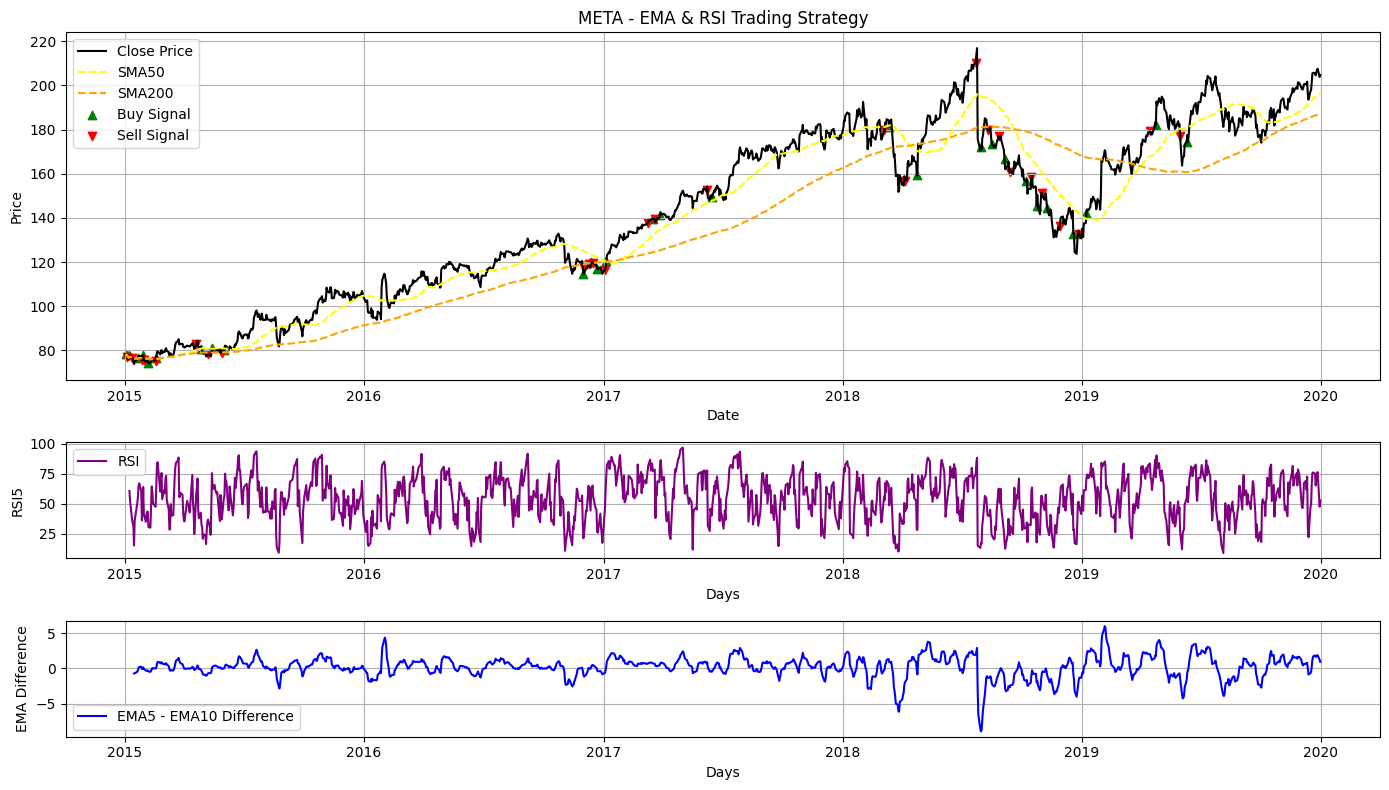

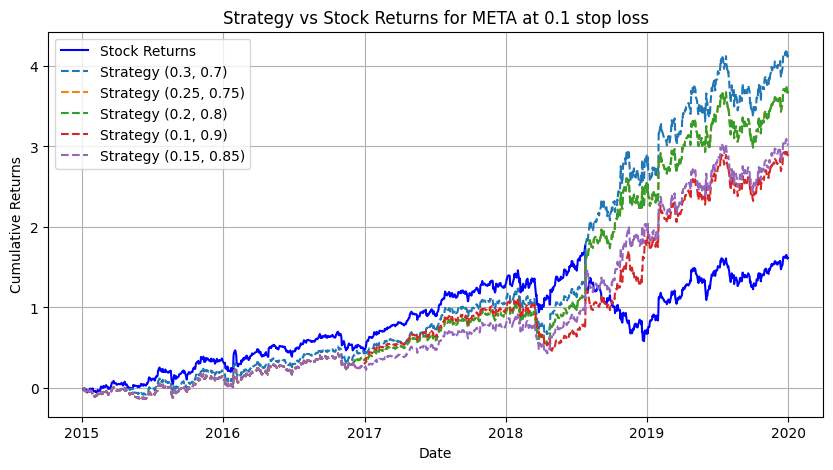

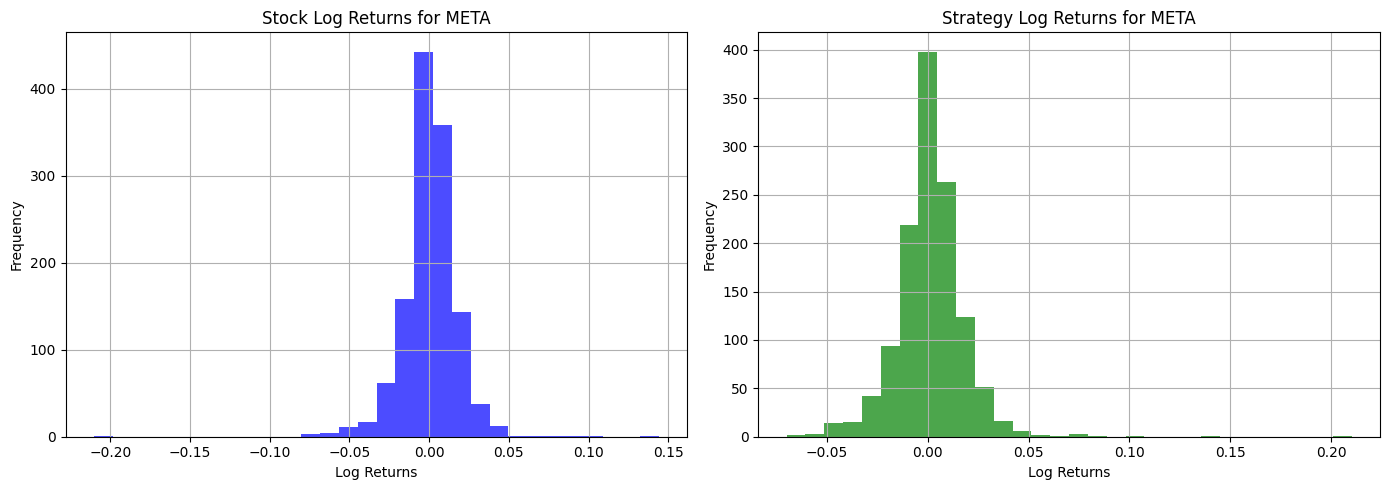

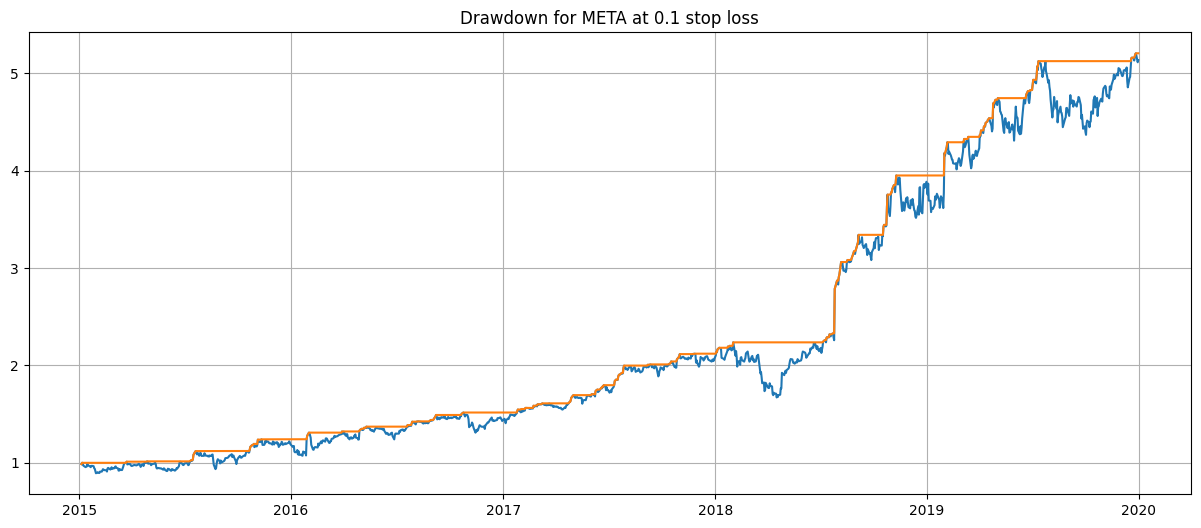

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


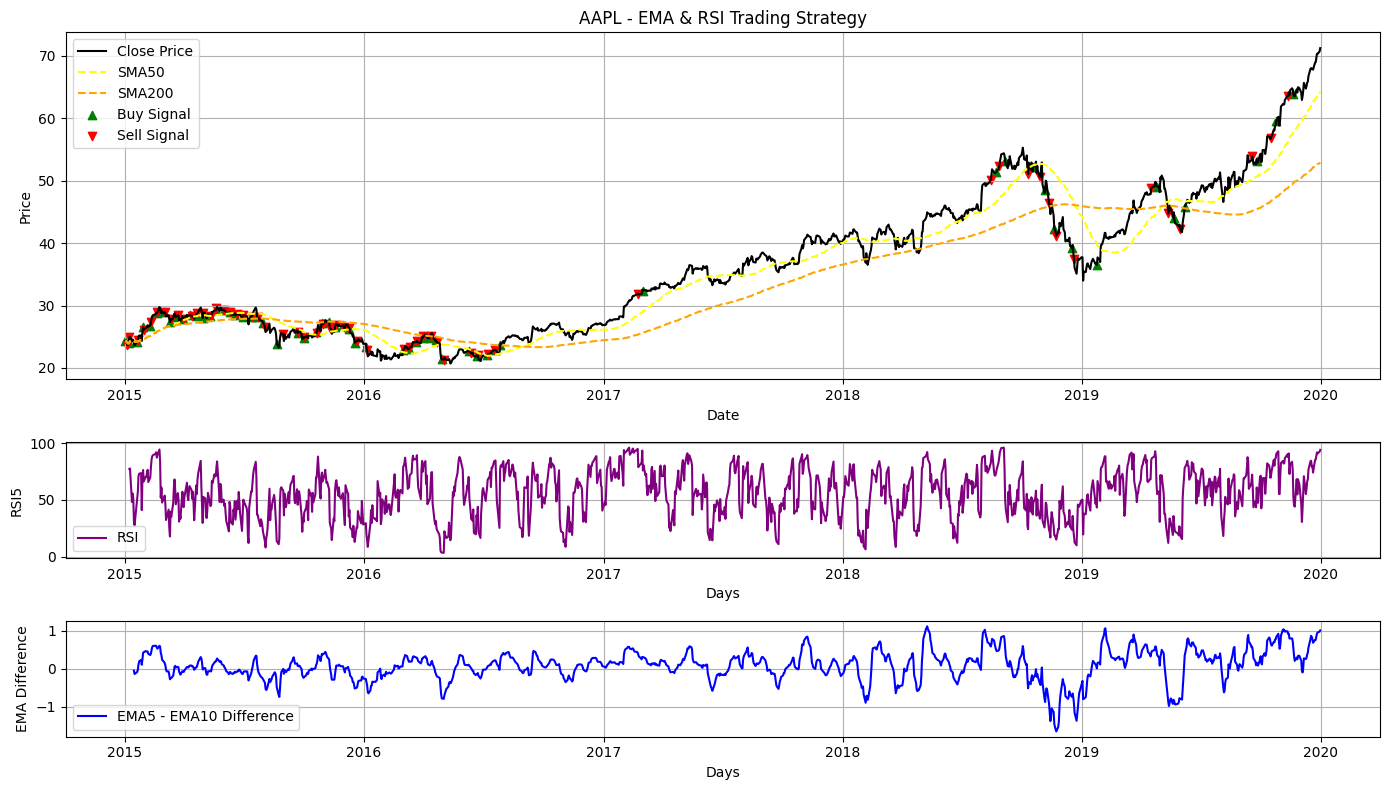

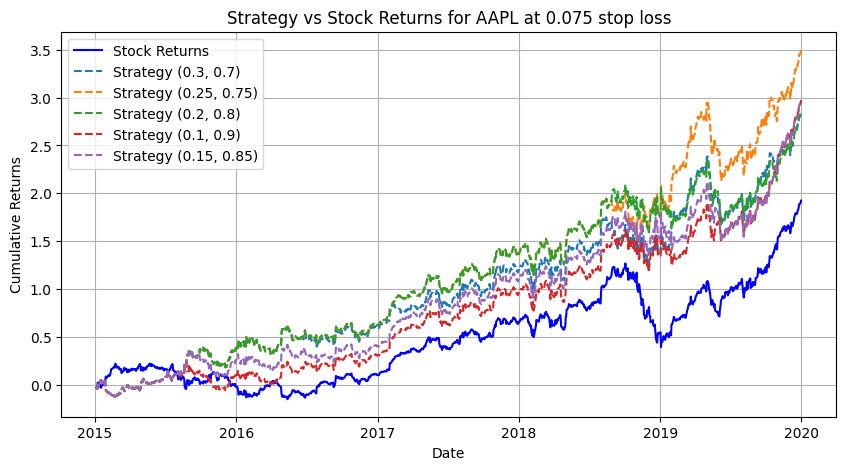

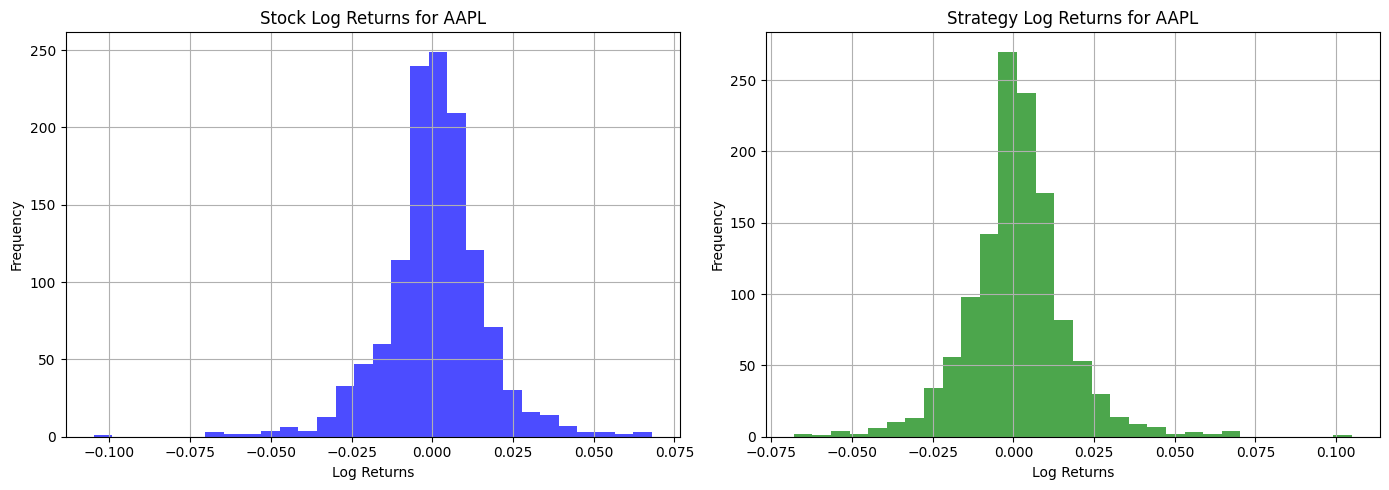

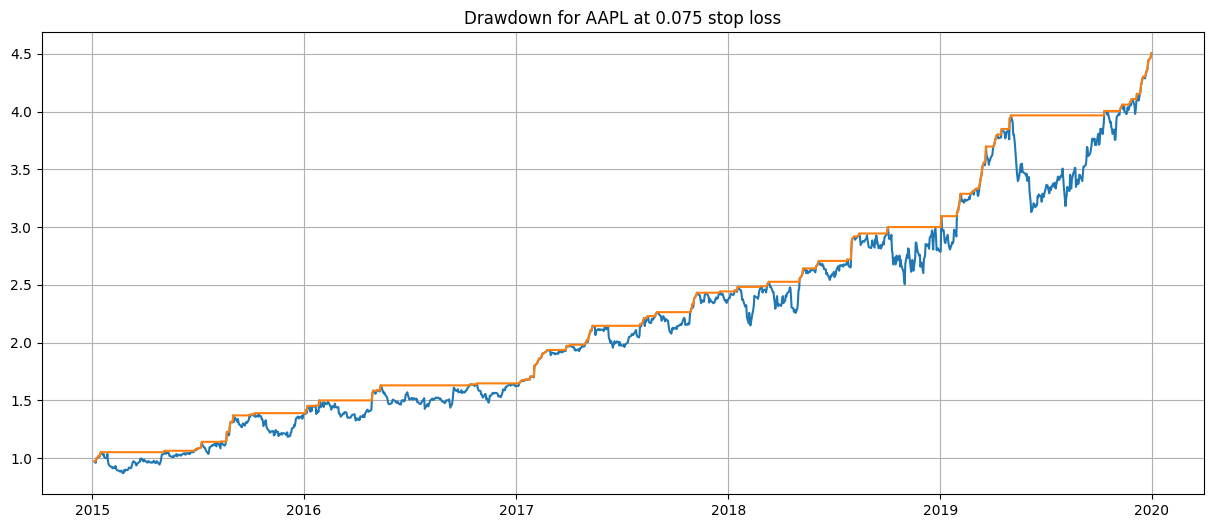

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


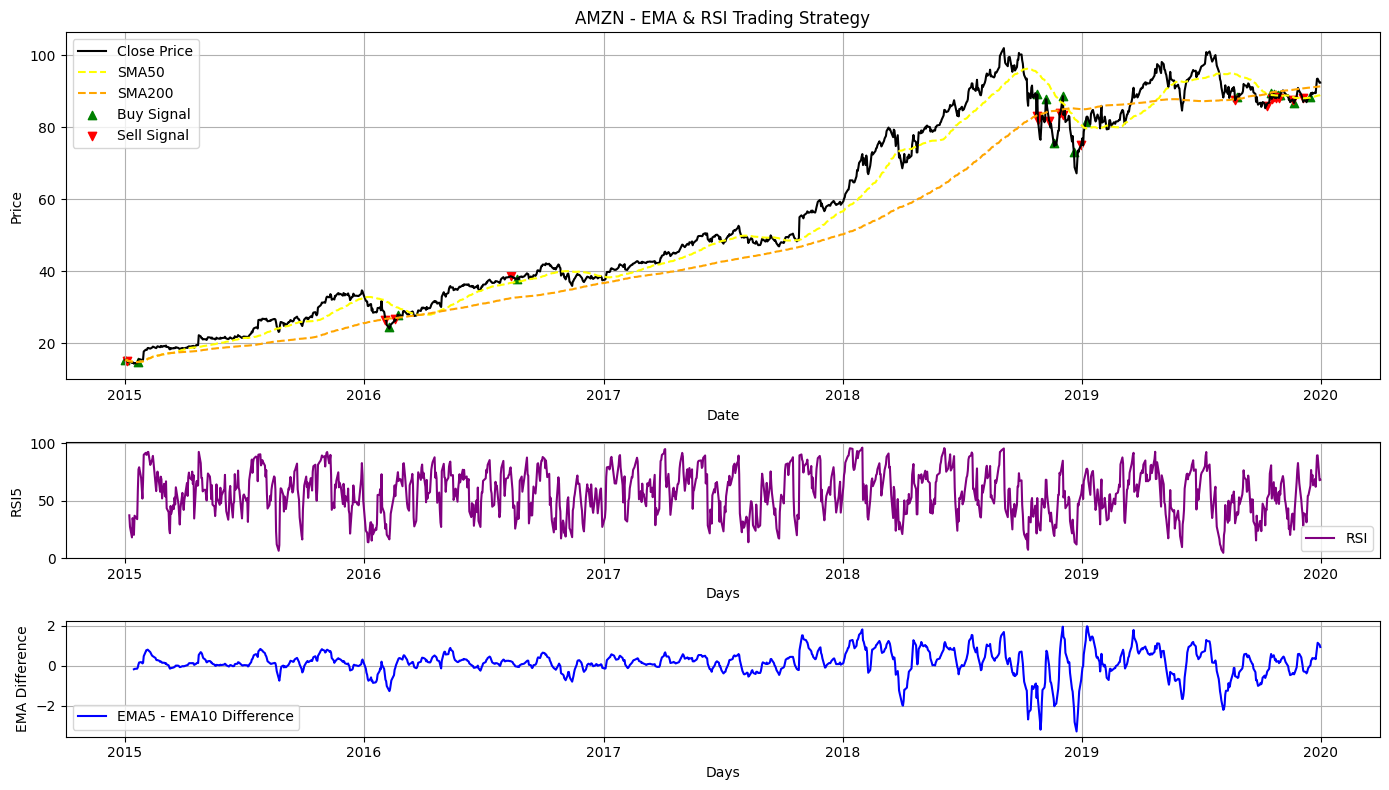

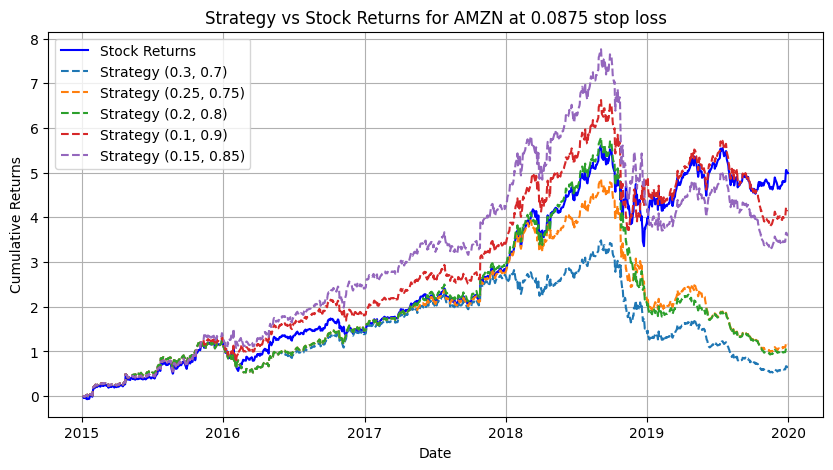

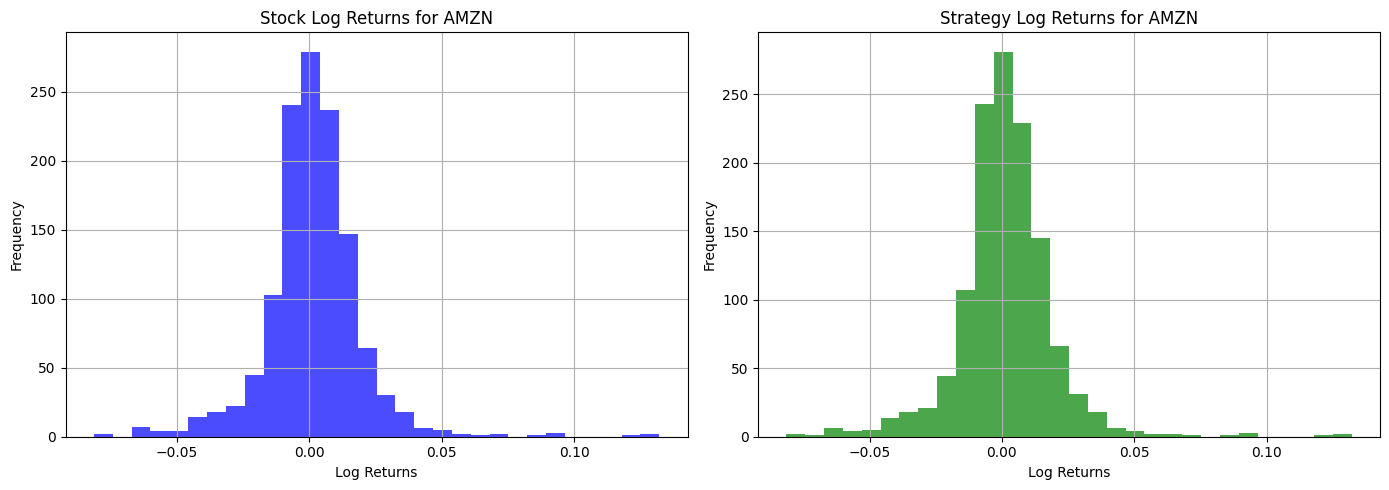

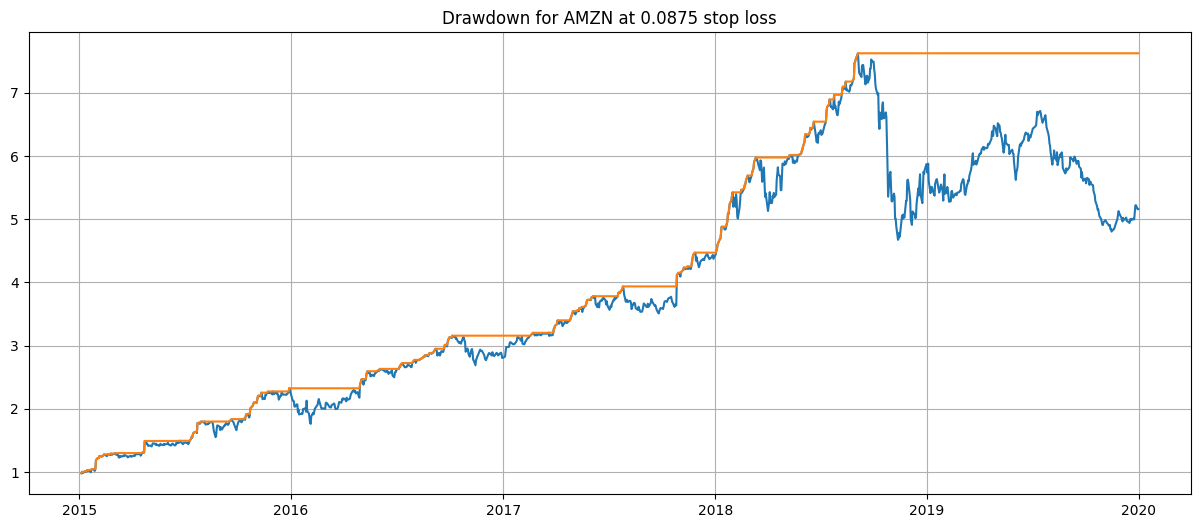

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


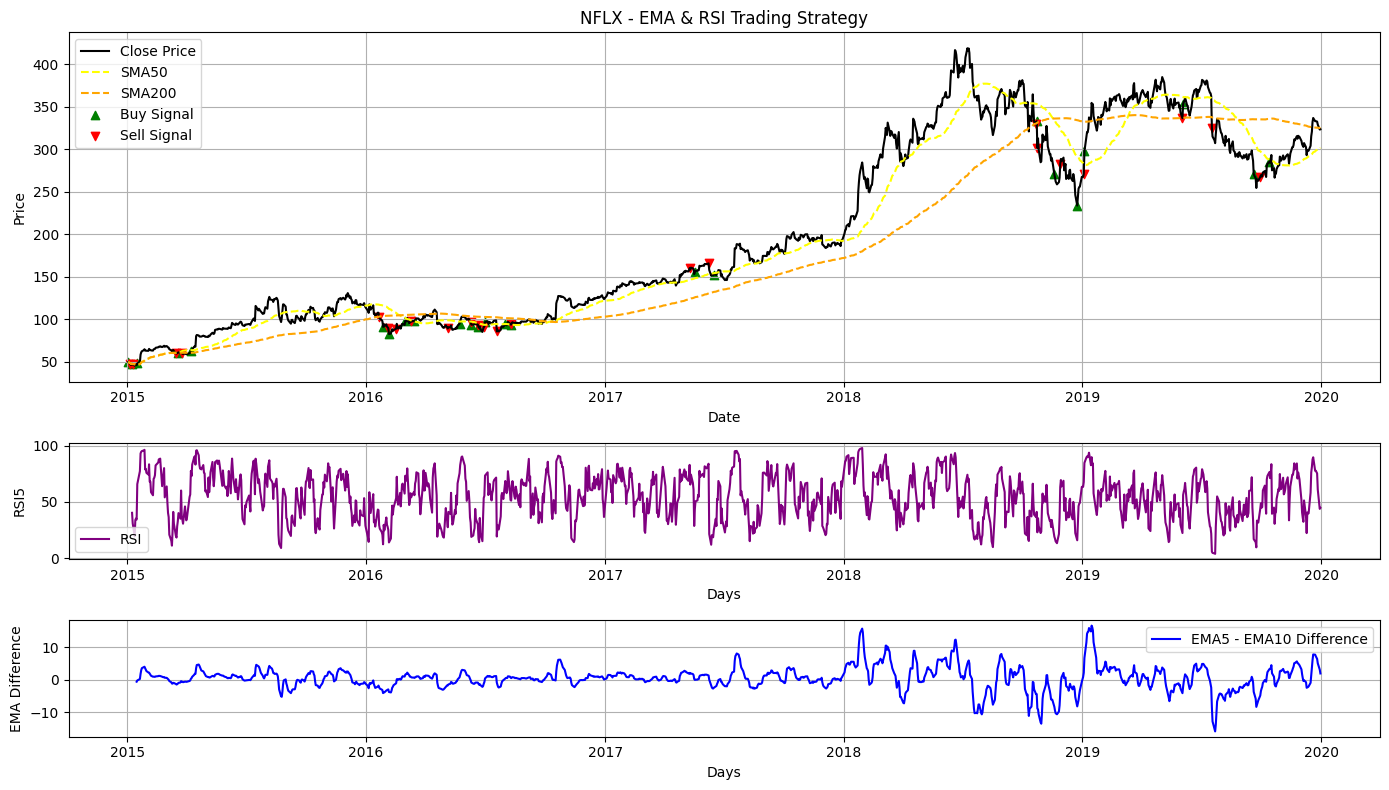

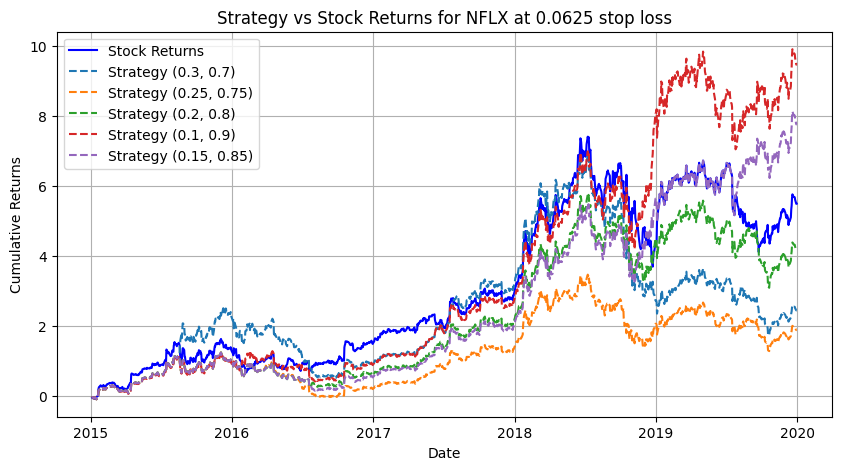

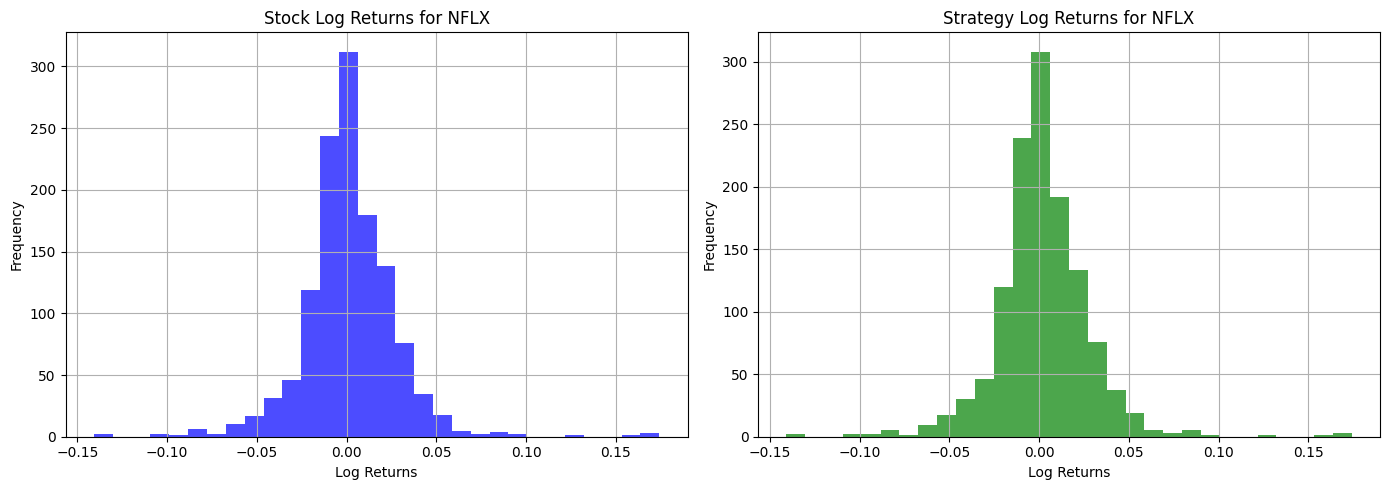

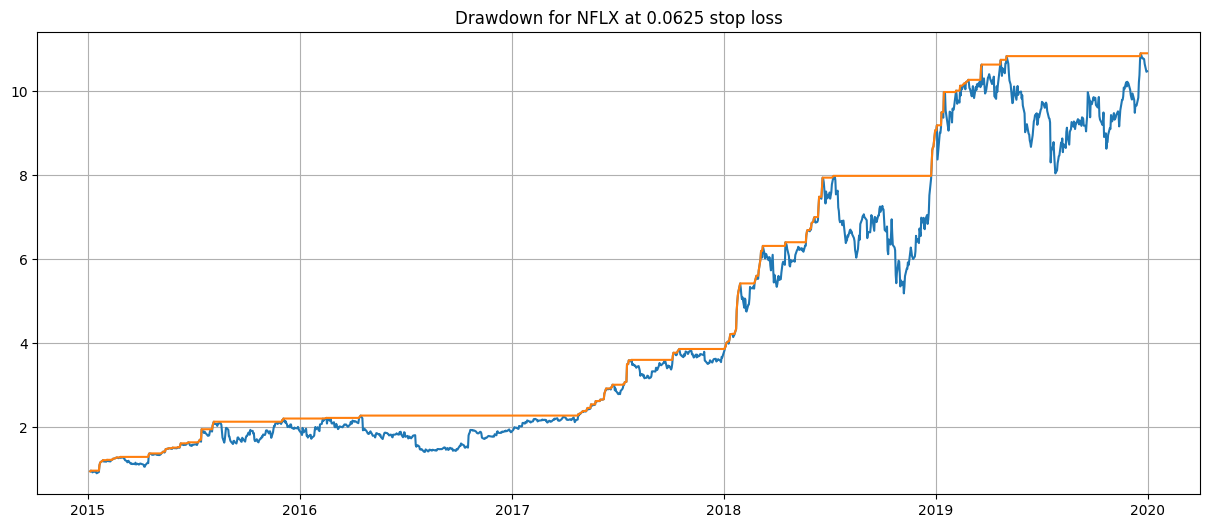

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


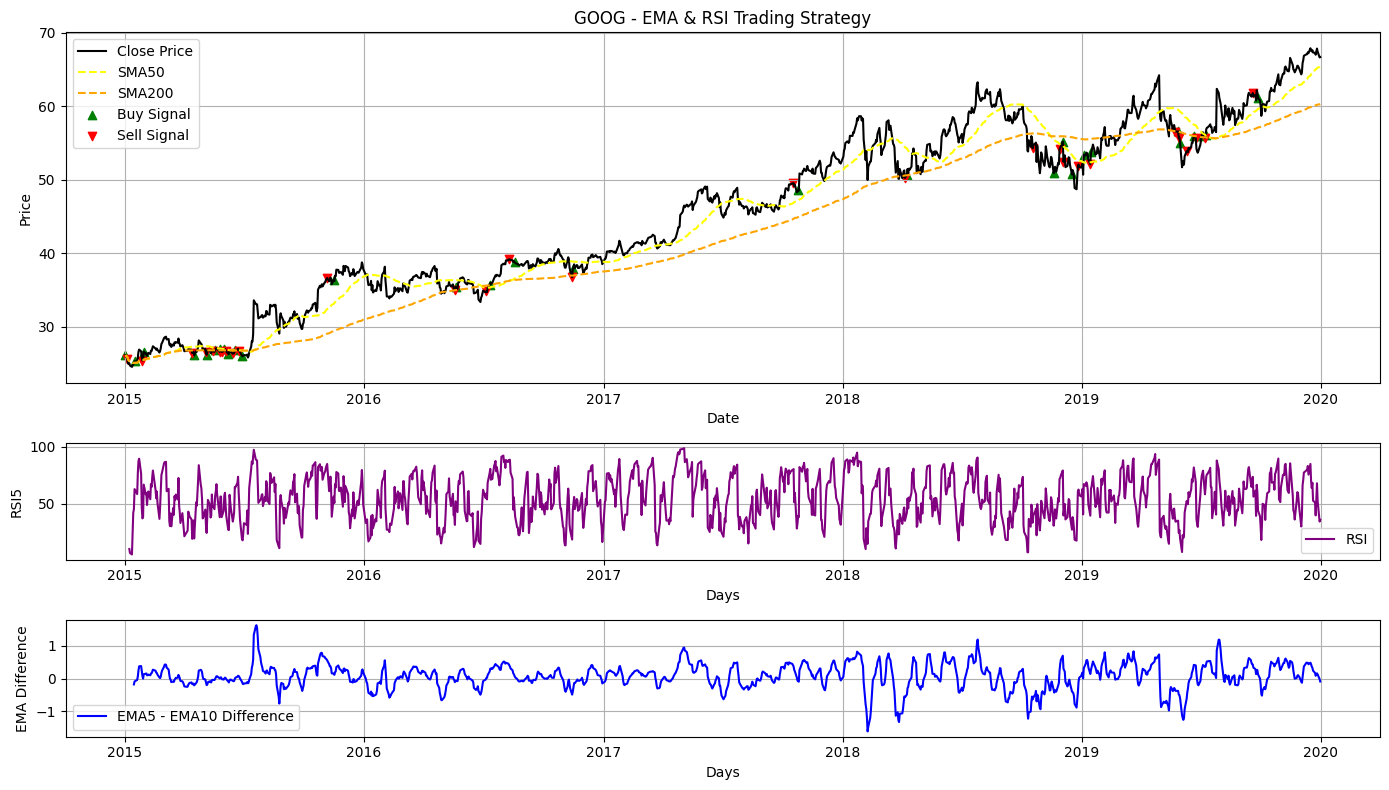

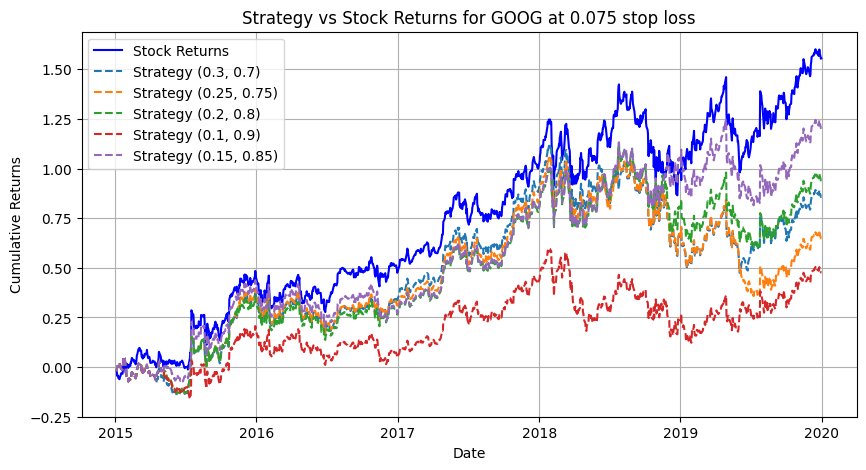

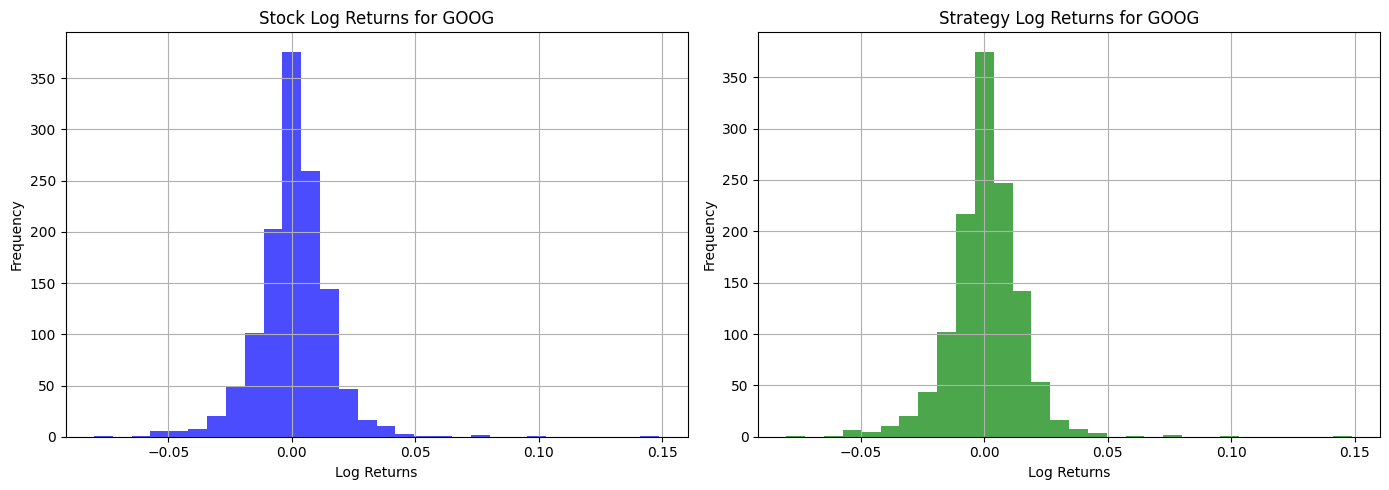

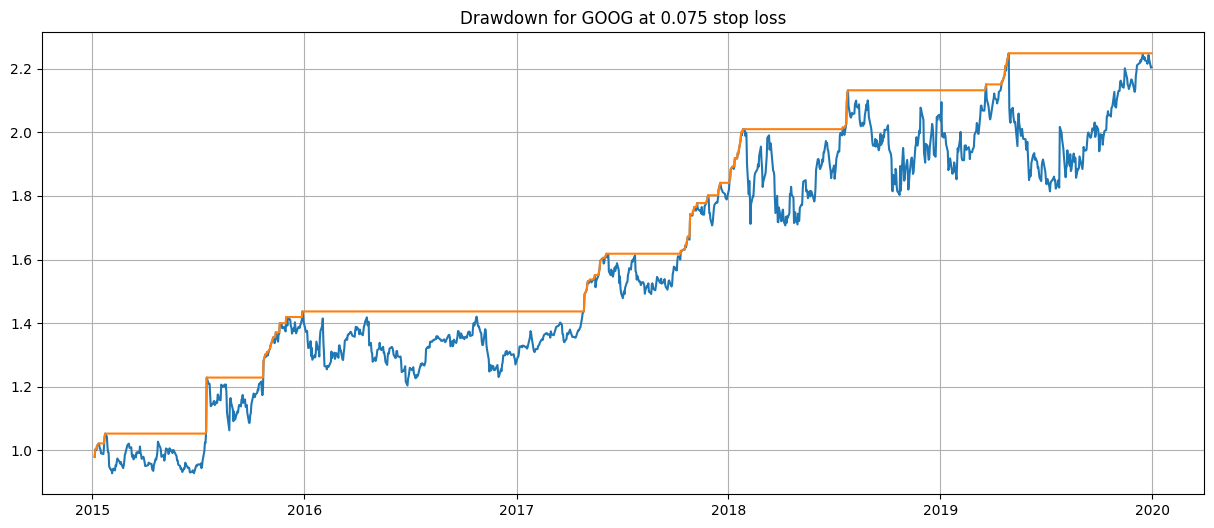

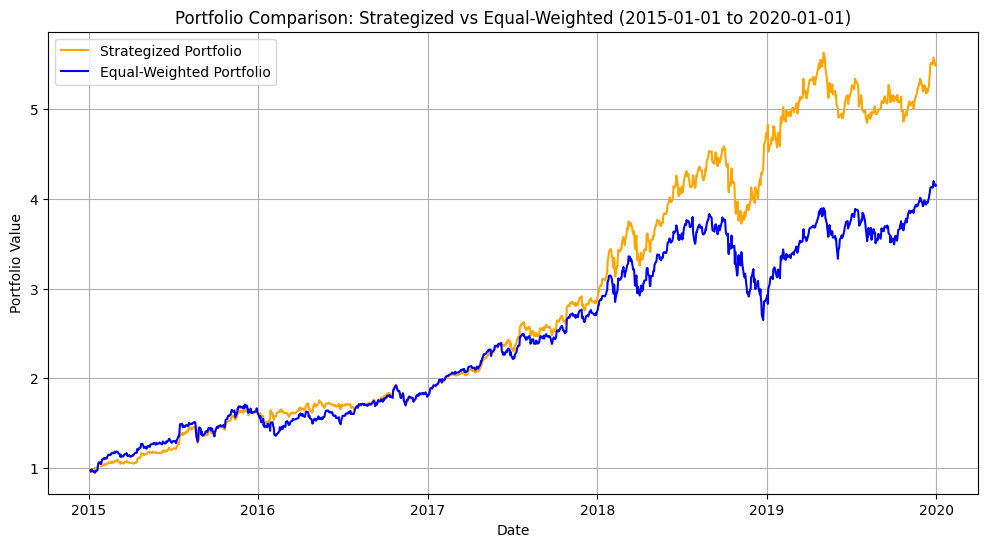

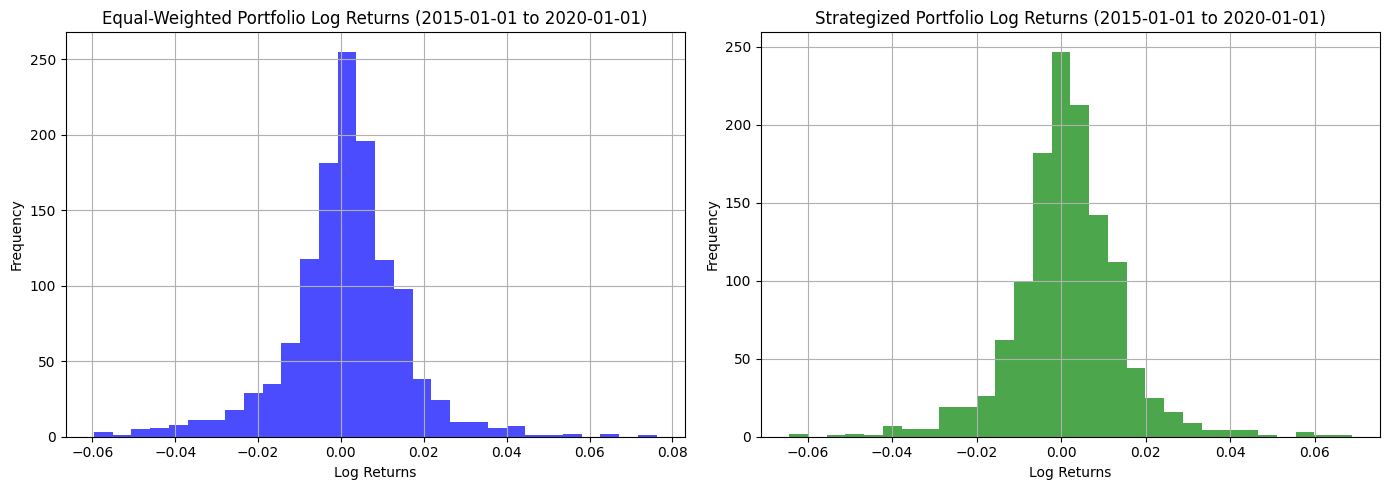

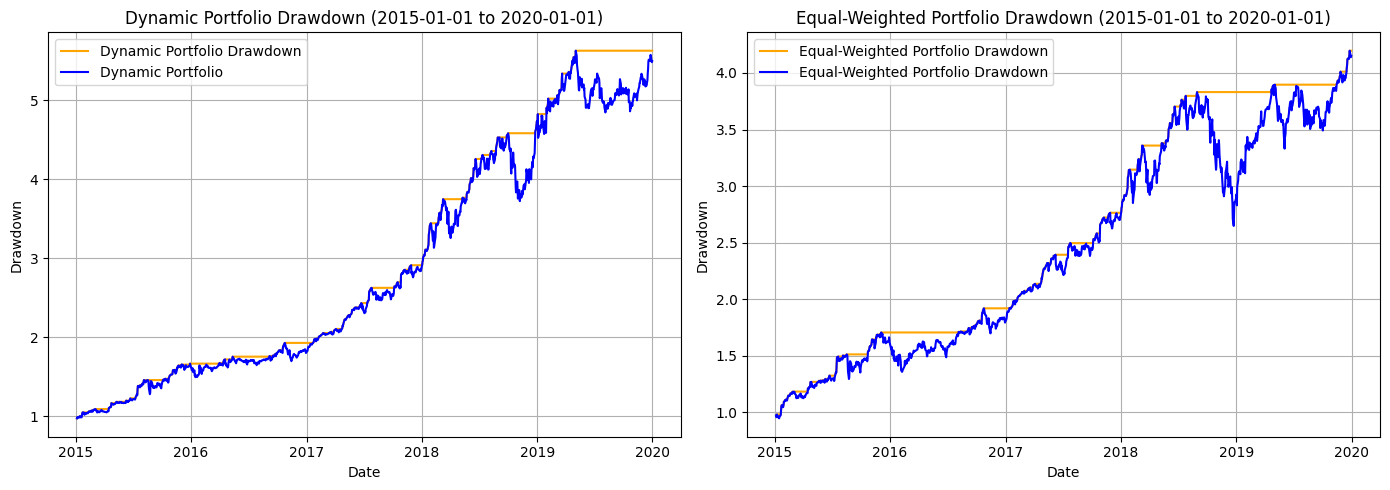

,Stock Returns,Strat Returns,Stock Alpha,Strat Alpha,Stock Beta,Strat Beta,Stock SD,Strat SD,Stock SR,Strat SR,Max Drawdown Stock,Max Drawdown Strat,Sortino Ratio Stock,Sortino Ratio Strat,Information Ratio Stock,Information Ratio Strat,Calmar Ratio Stock,Calmar Ratio Strat,Treynor Ratio Stock,Treynor Ratio Strat
META,0.232967,0.368888,0.092325,0.267139,1.183681,0.856344,0.282188,0.288891,0.825573,1.276909,1.191077,0.757494,1.178649,2.145509,0.486880,0.941306,0.195594,0.486985,0.196816,0.430771
AAPL,0.246032,0.332831,0.098398,0.334240,1.242525,-0.011863,0.248374,0.249501,0.990570,1.333984,0.873576,0.837267,1.432637,2.089543,0.680744,0.753625,0.281637,0.397520,0.198009,-28.056448
AMZN,0.401331,0.371464,0.244377,0.256900,1.320967,0.964209,0.292501,0.292597,1.372067,1.269542,2.254473,2.952363,2.190654,2.019036,1.194407,0.962880,0.178016,0.125819,0.303816,0.385253
NFLX,0.460873,0.556814,0.278816,0.468968,1.532241,0.739339,0.416752,0.416520,1.105868,1.336825,3.713045,2.798217,1.755014,2.152434,0.926182,1.079097,0.124123,0.198989,0.300784,0.753125
GOOG,0.216612,0.187102,0.075044,0.082368,1.191477,0.881471,0.240049,0.240108,0.902369,0.779244,0.558130,0.434262,1.377467,1.185515,0.540831,0.325957,0.388104,0.430852,0.181802,0.212262


In [26]:
# Run the strategy
stock_symbols = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]
start_date = '2015-01-01'
end_date = '2020-01-01'
stop_loss_range = [0.05, 0.0625, 0.075, 0.0875, 0.10]

# Step 1: Obtain benchmark returns
benchmark_data = yf.download('SPY', start=start_date, end=end_date)
filtered_benchmark_data = benchmark_data[['Close', 'Adj Close', 'Open']]
filtered_benchmark_data['Log Return'] = np.log(filtered_benchmark_data['Adj Close'] / filtered_benchmark_data['Adj Close'].shift(1))

# Step 2: Calculate equal-weighted portfolio returns
equal_weighted_portfolio_value, equal_weighted_portfolio_returns = calculate_equal_weighted_portfolio(stock_symbols, start_date, end_date)

# Step 3: Apply dynamic strategy for each stock and accumulate portfolio returns
portfolio_value = pd.DataFrame(index=equal_weighted_portfolio_returns.index)
portfolio_value['Dynamic Strategy Value'] = 0  # Initialize column to accumulate portfolio values
portfolio_returns = pd.DataFrame(index=equal_weighted_portfolio_returns.index)
portfolio_returns['Dynamic Strategy Returns'] = 0  # Initialize column to accumulate portfolio returns
portfolio_returns['Equal Weighted Portfolio Returns'] = equal_weighted_portfolio_returns  # Initialize column to store equal weighted portfolio returns
portfolio_returns['Benchmark Returns (SPY)'] = filtered_benchmark_data['Log Return'].apply(np.exp) - 1 # Initialize column to store benchmark returns in portfolio returns df

overall_individual_stock_metrics = pd.DataFrame() # initialize dataframe to store individual stock and dynamic strategy for individual stock metrics

for stock in stock_symbols:
    # Find the best stop loss for the current stock
    best_stop_loss, best_strategy_return = find_best_stop_loss(stock, start_date, end_date, stop_loss_range)

    # Initialize strategy with best stop loss for stock
    stock_strategy = Strategy(stock, start_date, end_date, best_stop_loss, filtered_benchmark_data)

    stock_strategy.generate_signals_positions()  # Generate signals and position
    dynamic_strategy_value, dynamic_strategy_returns = stock_strategy.calculate_strategy_returns() # store value and returns of individual stock
    portfolio_value[stock] = dynamic_strategy_value # store value
    portfolio_returns[stock] = dynamic_strategy_returns # store returns

    # Plot individual stock signals, returns, and histograms
    stock_strategy.plot_strategy_signals()
    stock_strategy.visualise_returns()
    stock_strategy.plot_histograms()
    stock_strategy.plot_drawdown()
    stock_metrics = stock_strategy.calculate_stock_metrics()
    overall_individual_stock_metrics = pd.concat([overall_individual_stock_metrics, stock_metrics])

# Calculate the average value for the strategized portfolio
portfolio_value['Dynamic Strategy Value'] = portfolio_value[stock_symbols].mean(axis=1)
# Calculate the average returns for the strategized portfolio
for stock in stock_symbols:
    portfolio_returns[stock] = np.exp(portfolio_returns[stock]) - 1 # Convert log returns to normal
    portfolio_returns['Dynamic Strategy Returns'] = portfolio_returns[stock_symbols].mean(axis=1)  # Average of normal returns

# Step 4: Plot the comparison between dynamic strategized portfolio vs equal-weighted portfolio

# log returns forr histogram comparison
equal_weighted_portfolio_log_returns = np.log(equal_weighted_portfolio_value / equal_weighted_portfolio_value.shift(1))
dynamic_portfolio_log_returns = np.log(portfolio_value['Dynamic Strategy Value'] / portfolio_value['Dynamic Strategy Value'].shift(1))


plot_portfolio_comparison(portfolio_value['Dynamic Strategy Value'], equal_weighted_portfolio_value, start_date, end_date)
plot_log_return_histogram_comparison(dynamic_portfolio_log_returns, equal_weighted_portfolio_log_returns, start_date, end_date)
plot_portfolio_drawdown_comparison(portfolio_value['Dynamic Strategy Value'], equal_weighted_portfolio_value, start_date, end_date)

# Step 5: Print overall stock metrics
overall_individual_stock_metrics

# Strategy Metrics

Calculate the metrics for equal weighted portfolio, our dynamic strategy portfolio and metrics on stocks that ran our dynamic strategy

In [28]:
# set risk free rate, assume to be 0
risk_free_rate = 0

# Remove NaN values
portfolio_returns = portfolio_returns.dropna()

# initialise dictionary
all_metrics = {}

# Calculate Beta
covariance_equal_weighted_strat = np.cov(portfolio_returns['Equal Weighted Portfolio Returns'], portfolio_returns['Benchmark Returns (SPY)'])[0, 1]
variance_benchmark = np.var(portfolio_returns['Benchmark Returns (SPY)'])
beta_equal_weighted_strat = covariance_equal_weighted_strat / variance_benchmark

covariance_dynamic_strat = np.cov(portfolio_returns['Dynamic Strategy Returns'], portfolio_returns['Benchmark Returns (SPY)'])[0, 1]
variance_benchmark = np.var(portfolio_returns['Benchmark Returns (SPY)'])
beta_dynamic_strat = covariance_dynamic_strat / variance_benchmark

# Calculate Alpha
equal_weighted_strat_yearly_return = portfolio_returns['Equal Weighted Portfolio Returns'].mean() * 252
dynamic_strat_yearly_return = portfolio_returns['Dynamic Strategy Returns'].mean() * 252
benchmark_yearly_return = portfolio_returns['Benchmark Returns (SPY)'].mean() * 252
alpha_equal_weighted_strat = (equal_weighted_strat_yearly_return - risk_free_rate - beta_equal_weighted_strat * (benchmark_yearly_return - risk_free_rate))
alpha_dynamic_strat = (dynamic_strat_yearly_return - risk_free_rate - beta_dynamic_strat * (benchmark_yearly_return - risk_free_rate))

# Calculate Standard Deviation
equal_weighted_strat_daily_sd = portfolio_returns['Equal Weighted Portfolio Returns'].std()
dynamic_strat_daily_sd = portfolio_returns['Dynamic Strategy Returns'].std()
std_dev_equal_weighted_strat = equal_weighted_strat_daily_sd * np.sqrt(252)  # Annualized standard deviation for Strategy
std_dev_dynamic_strat = dynamic_strat_daily_sd * np.sqrt(252)  # Annualized standard deviation for Stock

# Calculate Sharpe Ratio
daily_SR_equal_weighted_strat = (portfolio_returns['Equal Weighted Portfolio Returns'].mean() - risk_free_rate) / equal_weighted_strat_daily_sd
daily_SR_dynamic_strat = (portfolio_returns['Dynamic Strategy Returns'].mean() - risk_free_rate) / dynamic_strat_daily_sd
annual_SR_equal_weighted_strat = daily_SR_equal_weighted_strat * np.sqrt(252)
annual_SR_dynamic_strat = daily_SR_dynamic_strat * np.sqrt(252)

# Calculate Maximum Drawdown
cumulative_returns_equal_weighted_strat = (1 + portfolio_returns['Equal Weighted Portfolio Returns']).cumprod()
cum_max_equal_weighted_strat = cumulative_returns_equal_weighted_strat.cummax()
drawdown_equal_weighted_strat = cum_max_equal_weighted_strat - cumulative_returns_equal_weighted_strat
max_drawdown_equal_weighted_strat = drawdown_equal_weighted_strat.max()

cumulative_returns_dynamic_strat = (1 + portfolio_returns['Dynamic Strategy Returns']).cumprod()
cum_max_dynamic_strat = cumulative_returns_dynamic_strat.cummax()
drawdown_dynamic_strat = cum_max_dynamic_strat - cumulative_returns_dynamic_strat
max_drawdown_dynamic_strat = drawdown_dynamic_strat.max()

# Calculate Sortino Ratio
converted_returns_equal_weighted = portfolio_returns['Equal Weighted Portfolio Returns'].apply(lambda x: 0 if x > 0 else x)
squared_converted_returns_equal_weighted = converted_returns_equal_weighted ** 2
squared_sum_converted_returns_equal_weighted = np.sum(squared_converted_returns_equal_weighted)
downside_deviation_equal_weighted = np.sqrt(squared_sum_converted_returns_equal_weighted / len(converted_returns_equal_weighted))
annual_converted_sd_equal_weighted = downside_deviation_equal_weighted * np.sqrt(252)
sortino_equal_weighted_strat = (equal_weighted_strat_yearly_return) / annual_converted_sd_equal_weighted

converted_returns_dynamic_strat = portfolio_returns['Dynamic Strategy Returns'].apply(lambda x: 0 if x > 0 else x)
squared_converted_returns_dynamic_strat = converted_returns_dynamic_strat ** 2
squared_sum_converted_returns_dynamic_strat = np.sum(squared_converted_returns_dynamic_strat)
downside_deviation_dynamic_strat = np.sqrt(squared_sum_converted_returns_dynamic_strat / len(converted_returns_dynamic_strat))
annual_converted_sd_dynamic_strat = downside_deviation_dynamic_strat * np.sqrt(252)
sortino_dynamic_strat = (dynamic_strat_yearly_return) / annual_converted_sd_dynamic_strat

# Calculate Calmar Ratio
calmar_ratio_equal_weighted_strat = equal_weighted_strat_yearly_return / max_drawdown_equal_weighted_strat
calmar_ratio_dynamic_strat = dynamic_strat_yearly_return / max_drawdown_dynamic_strat

# Calculate Treynor Ratio
treynor_ratio_equal_weighted_strat = (equal_weighted_strat_yearly_return - risk_free_rate) / beta_equal_weighted_strat
treynor_ratio_dynamic_strat = (dynamic_strat_yearly_return - risk_free_rate) / beta_dynamic_strat

# Calculate Tracking Error and Information Ratio
tracking_error_equal_weighted_strat = np.std(portfolio_returns['Equal Weighted Portfolio Returns'] - portfolio_returns['Benchmark Returns (SPY)']) * np.sqrt(252)
info_ratio_equal_weighted_strat = (equal_weighted_strat_yearly_return - benchmark_yearly_return) / tracking_error_equal_weighted_strat

tracking_error_dynamic_strat = np.std(portfolio_returns['Dynamic Strategy Returns'] - portfolio_returns['Benchmark Returns (SPY)']) * np.sqrt(252)
info_ratio_dynamic_strat = (dynamic_strat_yearly_return - benchmark_yearly_return) / tracking_error_dynamic_strat

all_metrics['Equal Weighted Portfolio'] = [equal_weighted_strat_yearly_return, alpha_equal_weighted_strat,
                                           beta_equal_weighted_strat, std_dev_equal_weighted_strat,
                                           annual_SR_equal_weighted_strat, max_drawdown_equal_weighted_strat,
                                           sortino_equal_weighted_strat, calmar_ratio_equal_weighted_strat,
                                           treynor_ratio_equal_weighted_strat, info_ratio_equal_weighted_strat]

all_metrics['Dynamic Strategy Portfolio'] = [dynamic_strat_yearly_return, alpha_dynamic_strat,
                                             beta_dynamic_strat, std_dev_dynamic_strat,
                                             annual_SR_dynamic_strat, max_drawdown_dynamic_strat,
                                             sortino_dynamic_strat, calmar_ratio_dynamic_strat,
                                             treynor_ratio_dynamic_strat, info_ratio_dynamic_strat]

# MAANG Stocks Metrics Calculation
stock_symbols = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']

for stock in stock_symbols:
    # Calculate Beta
    covariance_stock = np.cov(portfolio_returns[stock], portfolio_returns['Benchmark Returns (SPY)'])[0, 1]
    beta_stock = covariance_stock / variance_benchmark

    # Calculate Alpha
    stock_yearly_return = portfolio_returns[stock].mean() * 252
    alpha_stock = stock_yearly_return - risk_free_rate - beta_stock * (benchmark_yearly_return - risk_free_rate)

    # Calculate Standard Deviation
    stock_daily_sd = portfolio_returns[stock].std()
    std_dev_stock = stock_daily_sd * np.sqrt(252)

    # Calculate Sharpe Ratio
    daily_SR_stock = (portfolio_returns[stock].mean() - risk_free_rate) / stock_daily_sd
    annual_SR_stock = daily_SR_stock * np.sqrt(252)

    # Calculate Maximum Drawdown
    cumulative_returns_stock = (1 + portfolio_returns[stock]).cumprod()
    cum_max_stock = cumulative_returns_stock.cummax()
    drawdown_stock = cum_max_stock - cumulative_returns_stock
    max_drawdown_stock = drawdown_stock.max()

    # Calculate Sortino Ratio
    converted_returns_stock = portfolio_returns[stock].apply(lambda x: 0 if x > 0 else x)
    squared_converted_returns_stock = converted_returns_stock ** 2
    squared_sum_converted_returns_stock = np.sum(squared_converted_returns_stock)
    downside_deviation_stock = np.sqrt(squared_sum_converted_returns_stock / len(converted_returns_stock))
    annual_converted_sd_stock = downside_deviation_stock * np.sqrt(252)
    sortino_stock = stock_yearly_return / annual_converted_sd_stock

    # Calculate Calmar Ratio
    calmar_ratio_stock = stock_yearly_return / max_drawdown_stock

    # Calculate Treynor Ratio
    treynor_ratio_stock = (stock_yearly_return - risk_free_rate) / beta_stock

    # Calculate Tracking Error and Information Ratio
    tracking_error_stock = np.std(portfolio_returns[stock] - portfolio_returns['Benchmark Returns (SPY)']) * np.sqrt(252)
    info_ratio_stock = (stock_yearly_return - benchmark_yearly_return) / tracking_error_stock

    # Store the metrics in the dictionary
    all_metrics[stock] = [stock_yearly_return, alpha_stock, beta_stock, std_dev_stock,
                          annual_SR_stock, max_drawdown_stock, sortino_stock,
                          calmar_ratio_stock, treynor_ratio_stock, info_ratio_stock]

metrics_columns = ['Returns', 'Alpha', 'Beta', 'Standard Deviation', 'Sharpe Ratio', 'Max Drawdown', 'Sortino Ratio', 'Calmar Ratio', 'Treynor Ratio', 'Information Ratio']

# Convert dictionary to DataFrame
metrics_df = pd.DataFrame.from_dict(all_metrics, orient='index', columns=metrics_columns)

metrics_df


,Returns,Alpha,Beta,Standard Deviation,Sharpe Ratio,Max Drawdown,Sortino Ratio,Calmar Ratio,Treynor Ratio,Information Ratio
Equal Weighted Portfolio,0.311563,0.157792,1.294178,0.228389,1.364180,1.182958,1.995577,0.263376,0.240742,1.256210
Dynamic Strategy Portfolio,0.363420,0.281923,0.685900,0.187717,1.935994,0.674009,3.028511,0.539192,0.529844,1.448104
META,0.368888,0.267139,0.856344,0.288891,1.276909,0.757494,2.145509,0.486985,0.430771,0.941306
AAPL,0.332831,0.334240,-0.011863,0.249501,1.333984,0.837267,2.089543,0.397520,-28.056448,0.753625
AMZN,0.371464,0.256900,0.964209,0.292597,1.269542,2.952363,2.019036,0.125819,0.385253,0.962880
NFLX,0.556814,0.468968,0.739339,0.416520,1.336825,2.798217,2.152434,0.198989,0.753125,1.079097
GOOG,0.187102,0.082368,0.881471,0.240108,0.779244,0.434262,1.185515,0.430852,0.212262,0.325957
